In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy  as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import itertools

In [4]:
def load_experiments(datasets, models, configurations, exps=None, seeds:list[int]=None, pred_lens:list[int]=None, verbose=False):
    mean_data, stdv_data = dict(), dict()
    for ds in datasets:
        mean_data[ds], stdv_data[ds] = dict(), dict()
        for m, cfg, exp in itertools.product(models, configurations, exps):
            model_cfg = f'{m}_{cfg:02d}_{exp:02d}'
            _mean_data, _stdv_data = dict(), []
            _path = f'results/{m}/{ds}/cfg{cfg:02d}'
            if not os.path.exists(_path):
                continue
            if not seeds:
                seeds_ = os.listdir(_path)
            else:
                seeds_ = [f'seed{s}' for s in seeds]
            for seed in seeds_:
                fpath = f'{_path}/{seed}/{exp}/eval_res.json'
                if not os.path.exists(fpath):
                    continue
                with open(fpath) as f:
                    res = json.load(f)
                    res = res['ours']
                    if pred_lens is None:
                        pred_lens_ = res.keys()
                    else:
                        pred_lens_ = [str(pl) for pl in pred_lens]
                    _mean_data[int(seed.replace('seed', ''))] = (np.mean([res[k]['norm']['MSE'] for k in pred_lens_]))
            if verbose: print(model_cfg, ds, _mean_data)
            _mean_data = list(_mean_data.values())
            if len(_mean_data) < 2:
                continue
            stdv_data[ds][model_cfg] = np.std(_mean_data)
            mean_data[ds][model_cfg] = np.mean(_mean_data)

    mean_data = pd.DataFrame.from_records(mean_data).sort_index().T.sort_index()
    mean_data = mean_data.dropna(axis=1, how='all')
    mean_data.loc['mean'] = mean_data.mean(axis=0)
    
    stdv_data = pd.DataFrame.from_records(stdv_data).sort_index().T.sort_index()
    stdv_data = stdv_data.dropna(axis=1, how='all')
    stdv_data.loc['mean'] = stdv_data.mean(axis=0)
    
    return mean_data, stdv_data

In [7]:
datasets = [
    'ETTh1', 'ETTh2', 
    # 'ETTm1', 'ETTm2'
]
models = [
    'ts2vec', 
    # 'ts2vec_byol', 
    # 'ts2vec_siam',
    # 'ts2vec_byol_lstm', 
    # 'ts2vec_siam_lstm', 
    'ts2vec_byol_lstm_augs', 
    'ts2vec_siam_lstm_augs', 
    # 'ts2vec_byol_proj',
    # 'ts2vec_siam_proj', 
    'ts2vec_byol_proj2_augs', 
    'ts2vec_siam_proj2_augs', 
]
configurations = [
    1, 
    23,
    37
]
seeds = [
    1, 42,
    2, 3, 
    # 6, 7
]

ts2vec_01_01 ETTh1 {1: 0.7853615133124691, 42: 0.739043483650536, 2: 0.7754869014357876, 3: 0.8125958189962142}
ts2vec_byol_lstm_augs_23_01 ETTh1 {1: 0.9555926356530092, 42: 1.0041607455189838, 2: 1.002238273310988, 3: 0.9670645463038821}
ts2vec_byol_lstm_augs_37_01 ETTh1 {1: 0.8649873226210346, 42: 0.8120639610428201, 2: 0.8605504257744077, 3: 0.8489131481900604}
ts2vec_siam_lstm_augs_37_01 ETTh1 {1: 0.9347754828307956, 42: 0.8235516709275348, 2: 0.8266165394131051, 3: 0.8415293044929835}
ts2vec_byol_proj2_augs_37_01 ETTh1 {1: 1.0285018003579118, 42: 0.9885428342607282, 2: 1.0194884042853916, 3: 0.9878880018506561}
ts2vec_siam_proj2_augs_37_01 ETTh1 {1: 1.060781651543517, 2: 0.9882650283888518}
ts2vec_01_01 ETTh2 {1: 1.4617214678387298, 42: 1.5544016699400427, 2: 1.6619708850167716, 3: 1.5138094728497915}
ts2vec_byol_lstm_augs_01_01 ETTh2 {1: 1.8941526617286837, 42: 1.7139085098865174, 2: 1.8143264248538284, 3: 1.8851476116010482}
ts2vec_byol_lstm_augs_23_01 ETTh2 {1: 1.50787428932278

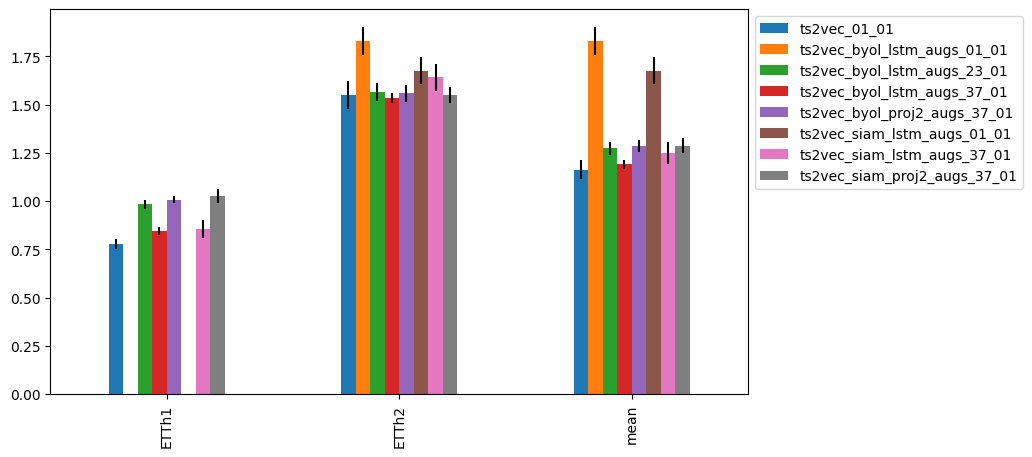

In [13]:
mean_data, stdv_data = load_experiments(datasets, models, configurations, [1], seeds, None, verbose=True)
ax = mean_data.plot.bar(yerr=stdv_data, figsize=(9, 5))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [14]:
def heatmap(data: pd.DataFrame):
    fig, ax = plt.subplots() 
    fig = ax.imshow(data.values)
    ax.set_xticks(range(len(data.columns)), labels=data.columns)
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.set_yticks(range(len(data.index)), labels=data.index)
    plt.setp(ax.get_yticklabels(), rotation=45)
    for x in range(len(data.columns)):
        for y in range(len(data.index)):
            _ = ax.text(x, y, '%.2f' % data.iloc[y, x], ha="center", va="center", color="w")

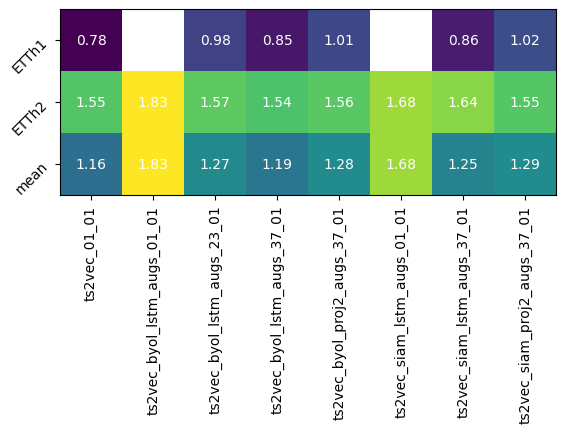

In [15]:
heatmap(mean_data)

In [36]:
path_ = '.'
def recursive_del_desktop_ini(path):
    for f in sorted(os.listdir(path)):
        path_f = f'{path}/{f}'
        if f in ['desktop.ini', '.uuid']:
            print(path_f)
            os.remove(path_f)
        elif os.path.isdir(path_f):
            recursive_del_desktop_ini(path_f)
recursive_del_desktop_ini(path_)